# Web Scraping for Indeed.com and Predicting Salaries

### Scraping job listings from Indeed.com

I will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, I will look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Each job listing is underneath a `div` tag with a class name of `result`. I can use BeautifulSoup to extract those. 

In [1]:
URL = 'https://www.indeed.co.uk/jobs?q=data+science&l=Birmingham&start=0'

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
from tqdm import tqdm

In [3]:
## YOUR CODE HERE
r = requests.get(URL)

soup = BeautifulSoup(r.text, 'html.parser')

jobs = soup.find_all(name='div', attrs={'class':"result"})
        

### Writing 4 functions to extract each item: location, company, job, and salary.

In [2]:
def extract_company_from_result(html):
    try:
        return html.find("span",{"class":"company"}).text
    except:
        return None

In [3]:
def extract_salary_from_result(html):
    try:
        return html.find("span",{"class":"no-wrap"}).text
    except:
        return None

In [4]:
def extract_location_from_result(html):   
    try:
        return html.find("span",{'class':'location'}).text
    except:
        return None


In [5]:
def extract_job_from_result(html):
    try:
        return html.find("a").text
    except:
        return None

In [229]:
url_template = "https://www.indeed.co.uk/jobs?q=data+science&l={}&start={}"
max_results_per_city = 2000
results = []

for city in ['Nottingham', 'Birmingham','Manchester','Leeds','Reading','Cardiff','Glasgow','Edinburgh','Newcastle',\
             'Liverpool','Bristol','Sheffield','York','Oxford','Cambridge','London']:
    for start in tqdm(range(0, max_results_per_city, 10)):
        r1 = requests.get(url_template.format(city,start))

        soup = BeautifulSoup(r1.text, 'html.parser')

        jobs = soup1.find_all(name='div', attrs={'class':"result"}) # Grab the results from the request (as above)
        results.extend(jobs) # Append to the full set of results

100%|██████████| 500/500 [05:40<00:00,  1.47it/s]


#### Using the functions I wrote above to parse out the 4 fields - location, title, company and salary. Creating a dataframe from the results with those 4 columns.

In [234]:
## YOUR CODE HERE
df = [{"job_title":extract_job_from_result(result),"company":extract_company_from_result(result),
      "location":extract_location_from_result(result),"salary":extract_salary_from_result(result)} for result in results]

In [237]:
df.replace(to_replace="\n",value="",regex=True,inplace=True)
df.head()

,company,job_title,location,salary
0,Bertelsmann SE & Co. KGaA,Bertelsmann Data Science Program 2018,United Kingdom,None
1,Equifax,Lead Data Analyst,Nottingham,None
2,Intel Ireland,Software Engineer – Driver Development - Reloc...,United Kingdom,None
3,Intel Ireland,"NPG Software Engineer - Relocating to Shannon,...",United Kingdom,None
4,Boots,Advanced Science Apprenticeship Programme,Nottingham,None


Lastly, I need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to me for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Finding the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, removing duplicate entries.

In [239]:
## YOUR CODE HERE
df = df.loc[~df['salary'].isnull()].drop_duplicates()
df = df.loc[df.salary.str.contains("year")]

#### Writing a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [7]:
def extract_number(salary):
    salary = str(salary).replace(",","").replace("£","").replace("$","")
    salary = [int(s) for s in salary.split() if s.isdigit()]
    if len(salary)>1:
        salary = (sum(salary)/2)
    else:
        salary = (sum(salary))
    return salary
extract_number("£35,683 - $45,467 a year")

40575.0


### Saving my results as a CSV

In [40]:
## YOUR CODE HERE
df_master = df.reset_index(drop=True)
df_master.to_csv("master_df.csv")

## Part 2: Factors that distinguish job category

Using the job postings I scraped for part 1 I will identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways I can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

#### Load in the the data of scraped salaries

In [1]:
df_master = pd.read_csv("master_df.csv")

In [21]:
df_master.drop("Unnamed: 0",axis=1,inplace=True)

In [23]:
df_master.head()

,company,job_title,location,salary
5,University of Nottingham,Smart Data Scientist - KTP Associate (Fixed-term),Nottingham,26000.0
6,Beauhurst,Data Curator,Nottingham,16000.0
10,Harnham,JUNIOR DATA SCIENTIST,Nottingham,32000.0
14,NERC,Environmental Statistician,Nottingham,33227.0
15,Beauhurst,Data Curator,Nottingham,16000.0


In [2]:
"""
potential job title keywords and groups:
Director
Analyst
Scientist
Engineer
Business
Consultant
Senior
Junior
Manager
Officer
Developer
Head of
Programmer
Executive
Java
Python
Lead
Intelligence
Machine Learning
Javascript
Developer
Graduate
Research

"""

'\npotential job title keywords and groups:\nDirector\nAnalyst\nScientist\nEngineer\nBusiness\nConsultant\nSenior\nJunior\nManager\nOfficer\nDeveloper\nHead of\nProgrammer\nExecutive\nJava\nPython\nLead\nIntelligence\nMachine Learning\nJavascript\nDeveloper\nGraduate\nResearch\n\n'

In [53]:
df_master.job_title.unique()

array(['Data Analyst', 'Data Scientist',
       'Director, Risk and Intelligence', 'Data Manager',
       'Software Engineer', 'Software Tester', 'Research Fellow',
       'Data Scientist - Commercial Banking',
       'Data Analyst - Birmingham, Up to £40k',
       'FINDS Scientific Officer',
       'Undergraduate Programme Administrator',
       'Administrator - Undergraduate Programmes', 'Business Analyst',
       'Biostatistician', 'O&M Performance Analyst',
       'Administrator Undergraduate Programmes: School of Dentistry...',
       'Microsoft Analytics Consultant', 'SAS/SQL- LEAD INSIGHT ANALYST',
       'Postdoctoral research fellow in blockchain for healthcare (0...',
       'Senior Analytics Manager - SAS, Hadoop, SQL, R ...',
       'Senior Analytics Manager', 'Graduate Statistical Analysts',
       'Senior Customer Analytics Manager',
       'Senior Data Mining Consultant – Analytics Solutions',
       'Software Developer',
       'Senior Insight Analyst - Birmingham, Perm

In [24]:
"""
potential company keywords:
University
HM Revenue and Customs
Home Office
Ltd
Limited
Recruitment
Department
Ministry
School
College
Bank
Recruit
Royal
Medic
Health
Government
McKinley
National
Education
British Gas
"""

sectors = {"Government":["HM", "Office", "Department", "Ministry", "Government", "National"],
 "Education":["School", "College", "Education", "University"],"Health":["Medic", "Health"],"Royal":["Royal"],
 "Recruitment":["Recruitment", "McKinley"],"Finance":["Finance", "Bank"],"Energy":["Energy", "Gas"]}

In [47]:
df_master.company.unique()

array(['    University of Nottingham', '    Beauhurst', '    Harnham',
       '    NERC', '    Cordius', '    Puma Energy LLP',
       '    Oscar Technology', '    University of Derby',
       '    HM Revenue and Customs', '    Müller UK & Ireland',
       '    ADAS', '    Ideagen Plc',
       '    Nottingham University Hospitals NHS Trust',
       'Data Science Talent', '    RP Analytics', '    Adecco',
       '    The Workbank Leicester', '    keaga.com',
       '    Rockfield Specialist Recruitment',
       '    Lexis Nexis Risk Solutions', '    Chemistree', '    PepsiCo',
       '    Microtex Products Ltd', '    Lexis Nexis',
       '    Salt Recruitment', '    Assystem UK', '    Jobs in Science',
       '    Michael Page UK', '    Qila Energy',
       '    Express Recruitment', '    People Force International',
       '    IBM Client Innovation Centre', '    Volt Europe',
       '    Elevation Recruitment', '    Aspire Data Recruitment',
       '    b3 Jobs Ltd', '    Chemistree S

In [25]:
categories = pd.DataFrame(columns=['Government','Education','Health','Royal','Recruitment','Finance','Energy'])

In [26]:
job_words = pd.DataFrame(columns=['Director','Analyst','Scientist','Engineer','Business','Consultant','Senior',
                                  'Junior','Manager','Officer','Developer','Head of','Programmer','Executive',
                                  'Java','Python','Lead','Intelligence','Machine Learning','Javascript','Developer',
                                  'Graduate','Research'])

In [27]:
df_master = pd.concat([df_master,categories,job_words],axis=1)

In [28]:
for key,value in sectors.items():
    df_master[key] = df_master.company.map(lambda x: 1 if len(set(x.split()).intersection(set(value)))>0 else 0)

In [29]:
for job in job_words:
    df_master[job] = df_master['job_title'].map(lambda x: 1 if job in x else 0)

#### I want to predict a binary variable - whether the salary was low or high. Computing the median salary and creating a new binary variable that is true when the salary is high (above the median).

In [30]:
df_master['salary_band'] = df_master.salary.map(lambda x: "low" if x <= df_master.salary.quantile(0.5) else "high")

In [31]:
df_master.head(10)

,company,job_title,location,salary,Government,Education,Health,Royal,Recruitment,Finance,Energy,Director,Analyst,Scientist,Engineer,Business,Consultant,Senior,Junior,Manager,Officer,Developer,Head of,Programmer,Executive,Java,Python,Lead,Intelligence,Machine Learning,Javascript,Developer,Graduate,Research,salary_band
5,University of Nottingham,Smart Data Scientist - KTP Associate (Fixed-term),Nottingham,26000.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,low
6,Beauhurst,Data Curator,Nottingham,16000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,low
10,Harnham,JUNIOR DATA SCIENTIST,Nottingham,32000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,high
14,NERC,Environmental Statistician,Nottingham,33227.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,high
15,Beauhurst,Data Curator,Nottingham,16000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,low
16,Beauhurst,Data Curator,Nottingham,16000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,low
18,NERC,Environmental Statistician,Nottingham,33227.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,high
20,University of Nottingham,Research Fellow (fixed term),Nottingham,34316.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,high
21,University of Nottingham,Research Associate/Fellow (fixed term),Nottingham,32664.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,high
25,Cordius,Data Scientist,Nottingham,30000.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,high


In [33]:
df_master.drop_duplicates(inplace=True)

In [34]:
df_master.shape

(1178, 35)

#### Thought experiment: What is the baseline accuracy for this model?

In [43]:
## YOUR CODE HERE
print("Baseline Accuracy:",final_df.salary_band.value_counts().max()/sum(final_df.salary_band.value_counts()))

Baseline Accuracy: 0.5009784735812133


## Preliminary EDA

In [39]:
final_df = df_master.copy()
final_df['salary_band'] = final_df.salary.map(lambda x: 0 if x <= final_df.salary.quantile(0.5) else 1)

In [41]:
final_df.shape

(1022, 36)

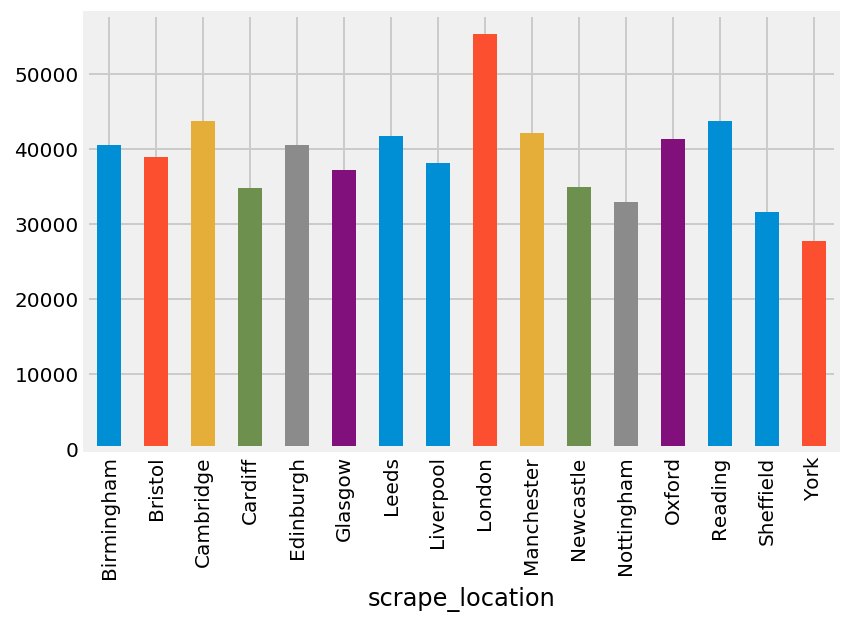

In [157]:
final_df.groupby(by="location").salary.mean().plot(kind="bar");

### SKLearn Logistic Regression

In [125]:
X = final_df['location']
y = final_df['salary_band']

In [127]:
X = pd.get_dummies(X) #dropping York in the predictors df, as this has the lowest mean salary as displayed above

In [128]:
X.drop("York",inplace=True)

In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from scipy import stats
import statsmodels.formula.api as sm
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

lr = LogisticRegression()

lr.fit(X,y)

print(lr.score(X,y))

lr.coef_
lr.intercept_

0.6144814090019569


array([-0.35420716])

## Adding new variables into Logistic Regression Model

In [130]:
final_df.head()
predictor_df = final_df.copy()

In [131]:
predictor_df.columns
predictor_df.drop(['company','job_title','location'],axis=1,inplace=True)

In [132]:
predictor_df.drop('salary',axis=1,inplace=True)

In [134]:
predictor_df = pd.get_dummies(predictor_df)

In [136]:
predictor_df.drop(labels="scrape_location_York",inplace=True)

In [137]:
y = predictor_df.pop('salary_band')

In [138]:
X_train, X_test, y_train, y_test = train_test_split(predictor_df,y,test_size=0.3,random_state=2018)

In [139]:
cross_val_score(lr,X_train,y_train,cv=5).mean()

0.7370138273307287

In [141]:
lr.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>

In [142]:
from sklearn.model_selection import GridSearchCV
params = {'C':np.logspace(-5,5,50),
          'penalty':['l1','l2']}
lrgs = GridSearchCV(lr,params,verbose=1,cv=5)
lrgs.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-05, 1.59986e-05, 2.55955e-05, 4.09492e-05, 6.55129e-05,
       1.04811e-04, 1.67683e-04, 2.68270e-04, 4.29193e-04, 6.86649e-04,
       1.09854e-03, 1.75751e-03, 2.81177e-03, 4.49843e-03, 7.19686e-03,
       1.15140e-02, 1.84207e-02, 2.94705e-02, 4.71487e-02, 7.54312e...,
       1.52642e+04, 2.44205e+04, 3.90694e+04, 6.25055e+04, 1.00000e+05]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [143]:
lrgs.best_params_

{'C': 0.30888435964774846, 'penalty': 'l2'}

In [144]:
lrgs.best_score_

0.7454545454545455

In [145]:
best_lr = lrgs.best_estimator_

In [146]:
coefficient_df = pd.DataFrame()
coefficient_df['Features'] = X_train.columns
coefficient_df['LR_Coefficients'] = best_lr.coef_[0]
coefficient_df['absolutes'] = abs(best_lr.coef_[0])

In [148]:
coefficient_df.sort_values(by='absolutes',ascending=False).head(10)

,Features,LR_Coefficients,absolutes
28,Graduate,-1.480006,1.480006
13,Senior,1.423608,1.423608
15,Manager,1.120301,1.120301
16,Officer,-1.113746,1.113746
38,scrape_location_London,1.030148,1.030148
14,Junior,-0.993930,0.993930
29,Research,-0.948223,0.948223
23,Lead,0.864313,0.864313
10,Engineer,0.823720,0.823720
1,Education,-0.788695,0.788695


In [149]:
best_lr.score(X_test,y_test)

0.7231270358306189

In [253]:
predictions = best_lr.predict(X_test)
predictions_df = pd.DataFrame()
predictions_df['y_true'] = y_test
predictions_df['y_hat'] = predictions
predictions_df['prob_1'] = best_lr.predict_proba(X_test)[:,1]
predictions_df['70_percent_threshold'] = predictions_df['prob_1'].map(lambda x: 1 if x>0.7 else 0)
predictions_df.head(10)

,y_true,y_hat,prob_1,70_percent_threshold
1098,0,0,0.488317,0
311,1,1,0.840732,1
601,0,0,0.066136,0
49,1,1,0.655551,0
1073,1,1,0.650745,0
165,0,0,0.388141,0
28,0,0,0.431208,0
1091,1,1,0.831459,1
86,0,0,0.383015,0
604,1,1,0.502344,0


In [267]:
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve, auc, average_precision_score

f1_score(y_test, predictions_df['70_percent_threshold'])

0.5938864628820961

In [234]:
fpr, tpr, thresh = roc_curve(y_test,predictions_df['prob_1'])
thresholds_df = pd.DataFrame()
thresholds_df['FPR'] = fpr
thresholds_df['TPR'] = tpr
thresholds_df['Thresholds'] = thresh
thresholds_df.iloc[30:70,:].head()

,FPR,TPR,Thresholds
30,0.113208,0.493243,0.678892
31,0.113208,0.520270,0.655551
32,0.119497,0.560811,0.650745
33,0.119497,0.574324,0.646612
34,0.138365,0.574324,0.635684


In [262]:
prec, recall, thresh = precision_recall_curve(y_test,predictions_df['prob_1'])
prc_df = pd.DataFrame()
prc_df['Precision'] = prec[:-1]
prc_df['Recall'] = recall[:-1]
prc_df['Threshold'] = thresh


In [269]:
average_precision = average_precision_score(y_test, predictions_df['prob_1'])

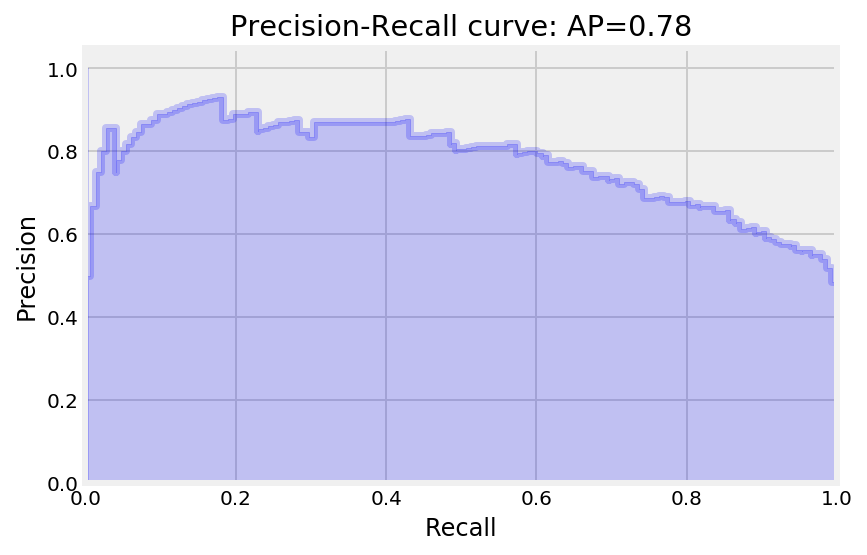

In [272]:
plt.step(recall, prec, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, prec, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));

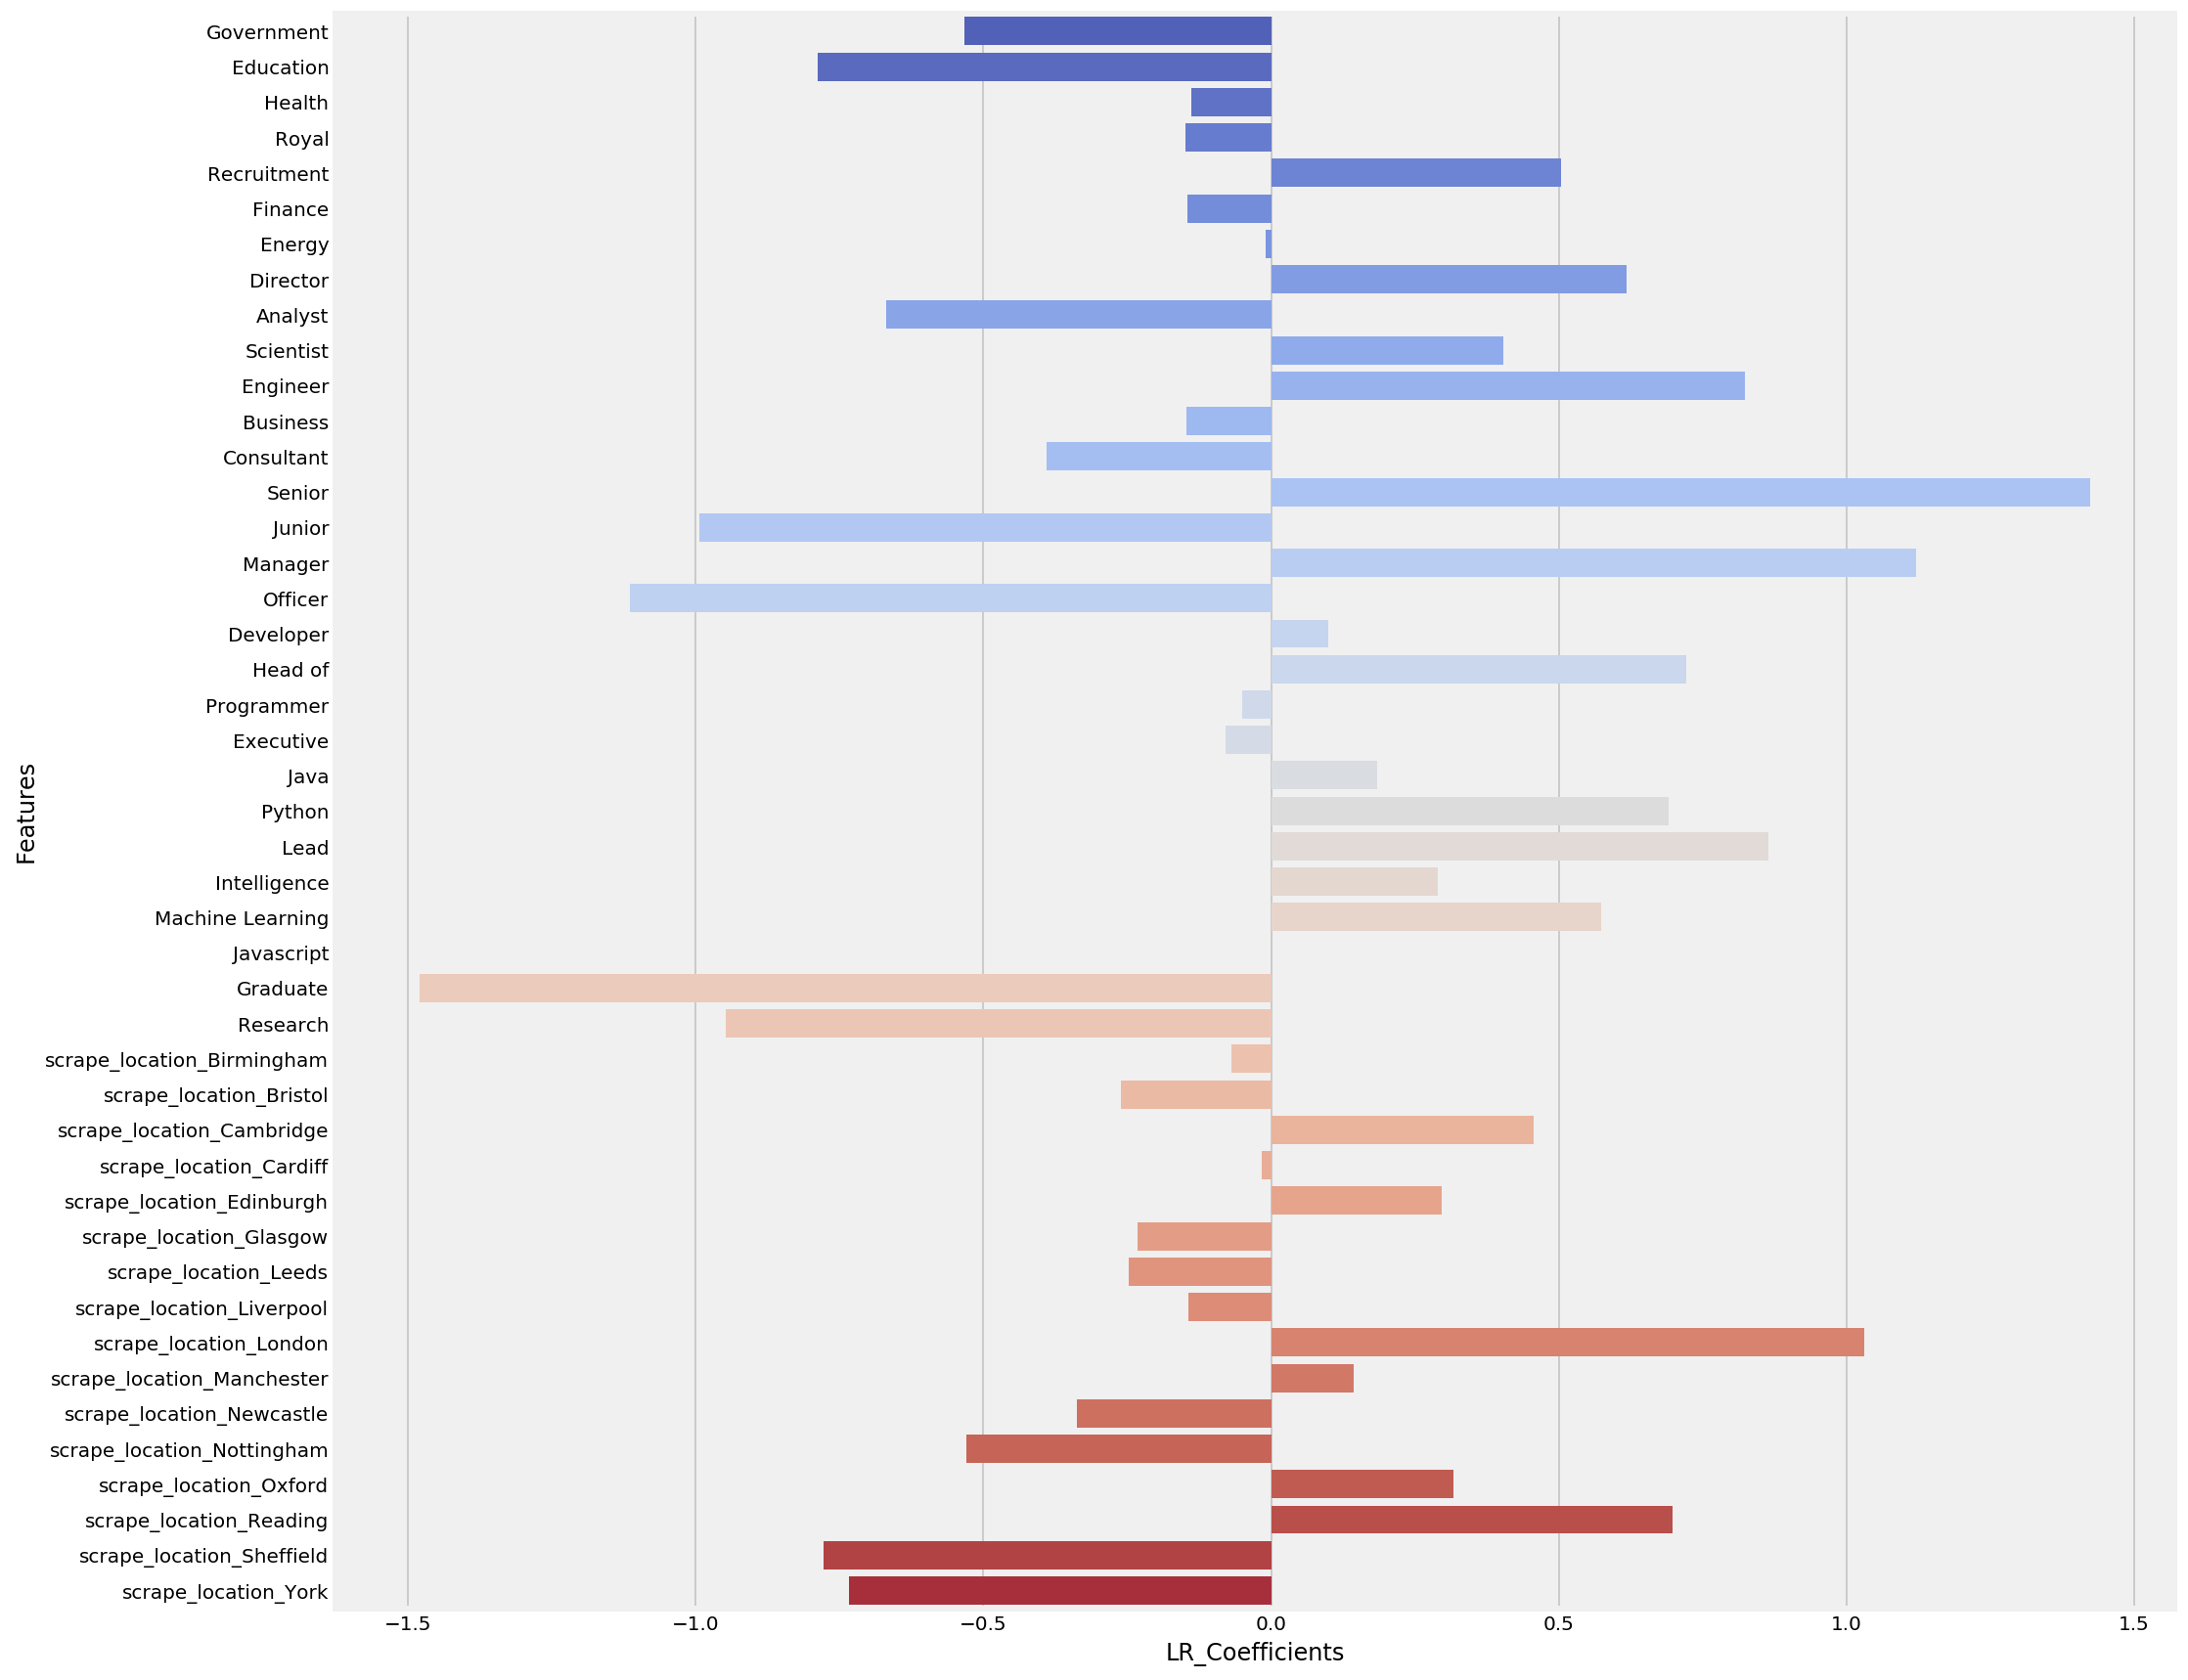

In [222]:
fig,ax= plt.subplots(figsize=(15,15))
sns.barplot(y=coefficient_df.Features,x=coefficient_df.LR_Coefficients, orient='h', palette='coolwarm',ax=ax);

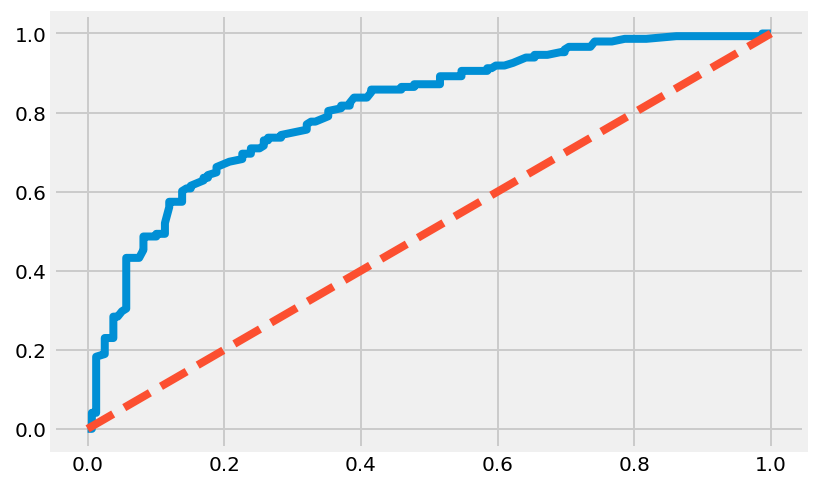

In [190]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'--');

## Trying Random Forest Classifier

In [193]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=5)
cross_val_score(rfc,X_train,y_train,cv=5).mean()

0.7355856780152555

In [195]:
rfc.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [200]:
X_train.shape

(715, 46)

In [206]:
params = {'max_depth':range(1,21),
          'max_features':["auto","log2",0.5],
         'criterion':['gini','entropy'],
         'bootstrap':[True,False],
         }
rfgs = GridSearchCV(rfc,params,verbose=1,cv=5)
rfgs.fit(X_train,y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   23.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 21), 'max_features': ['auto', 'log2', 0.5], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [207]:
rfgs.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 11,
 'max_features': 'log2'}

In [210]:
rfgs.best_score_

0.7636363636363637

In [211]:
best_rf = rfgs.best_estimator_

In [213]:
rf_coefficient_df = pd.DataFrame()
rf_coefficient_df['Features'] = X_train.columns
rf_coefficient_df['Feature_Importances'] = best_rf.feature_importances_

In [224]:
rf_coefficient_df.sort_values(by='Feature_Importances',ascending=False).head(10)

,Features,Feature_Importances
1,Education,0.095724
13,Senior,0.095147
28,Graduate,0.070581
38,scrape_location_London,0.062752
29,Research,0.061604
10,Engineer,0.055091
15,Manager,0.046546
14,Junior,0.045642
16,Officer,0.036571
8,Analyst,0.029815


In [225]:
best_rf.score(X_test,y_test)

0.742671009771987

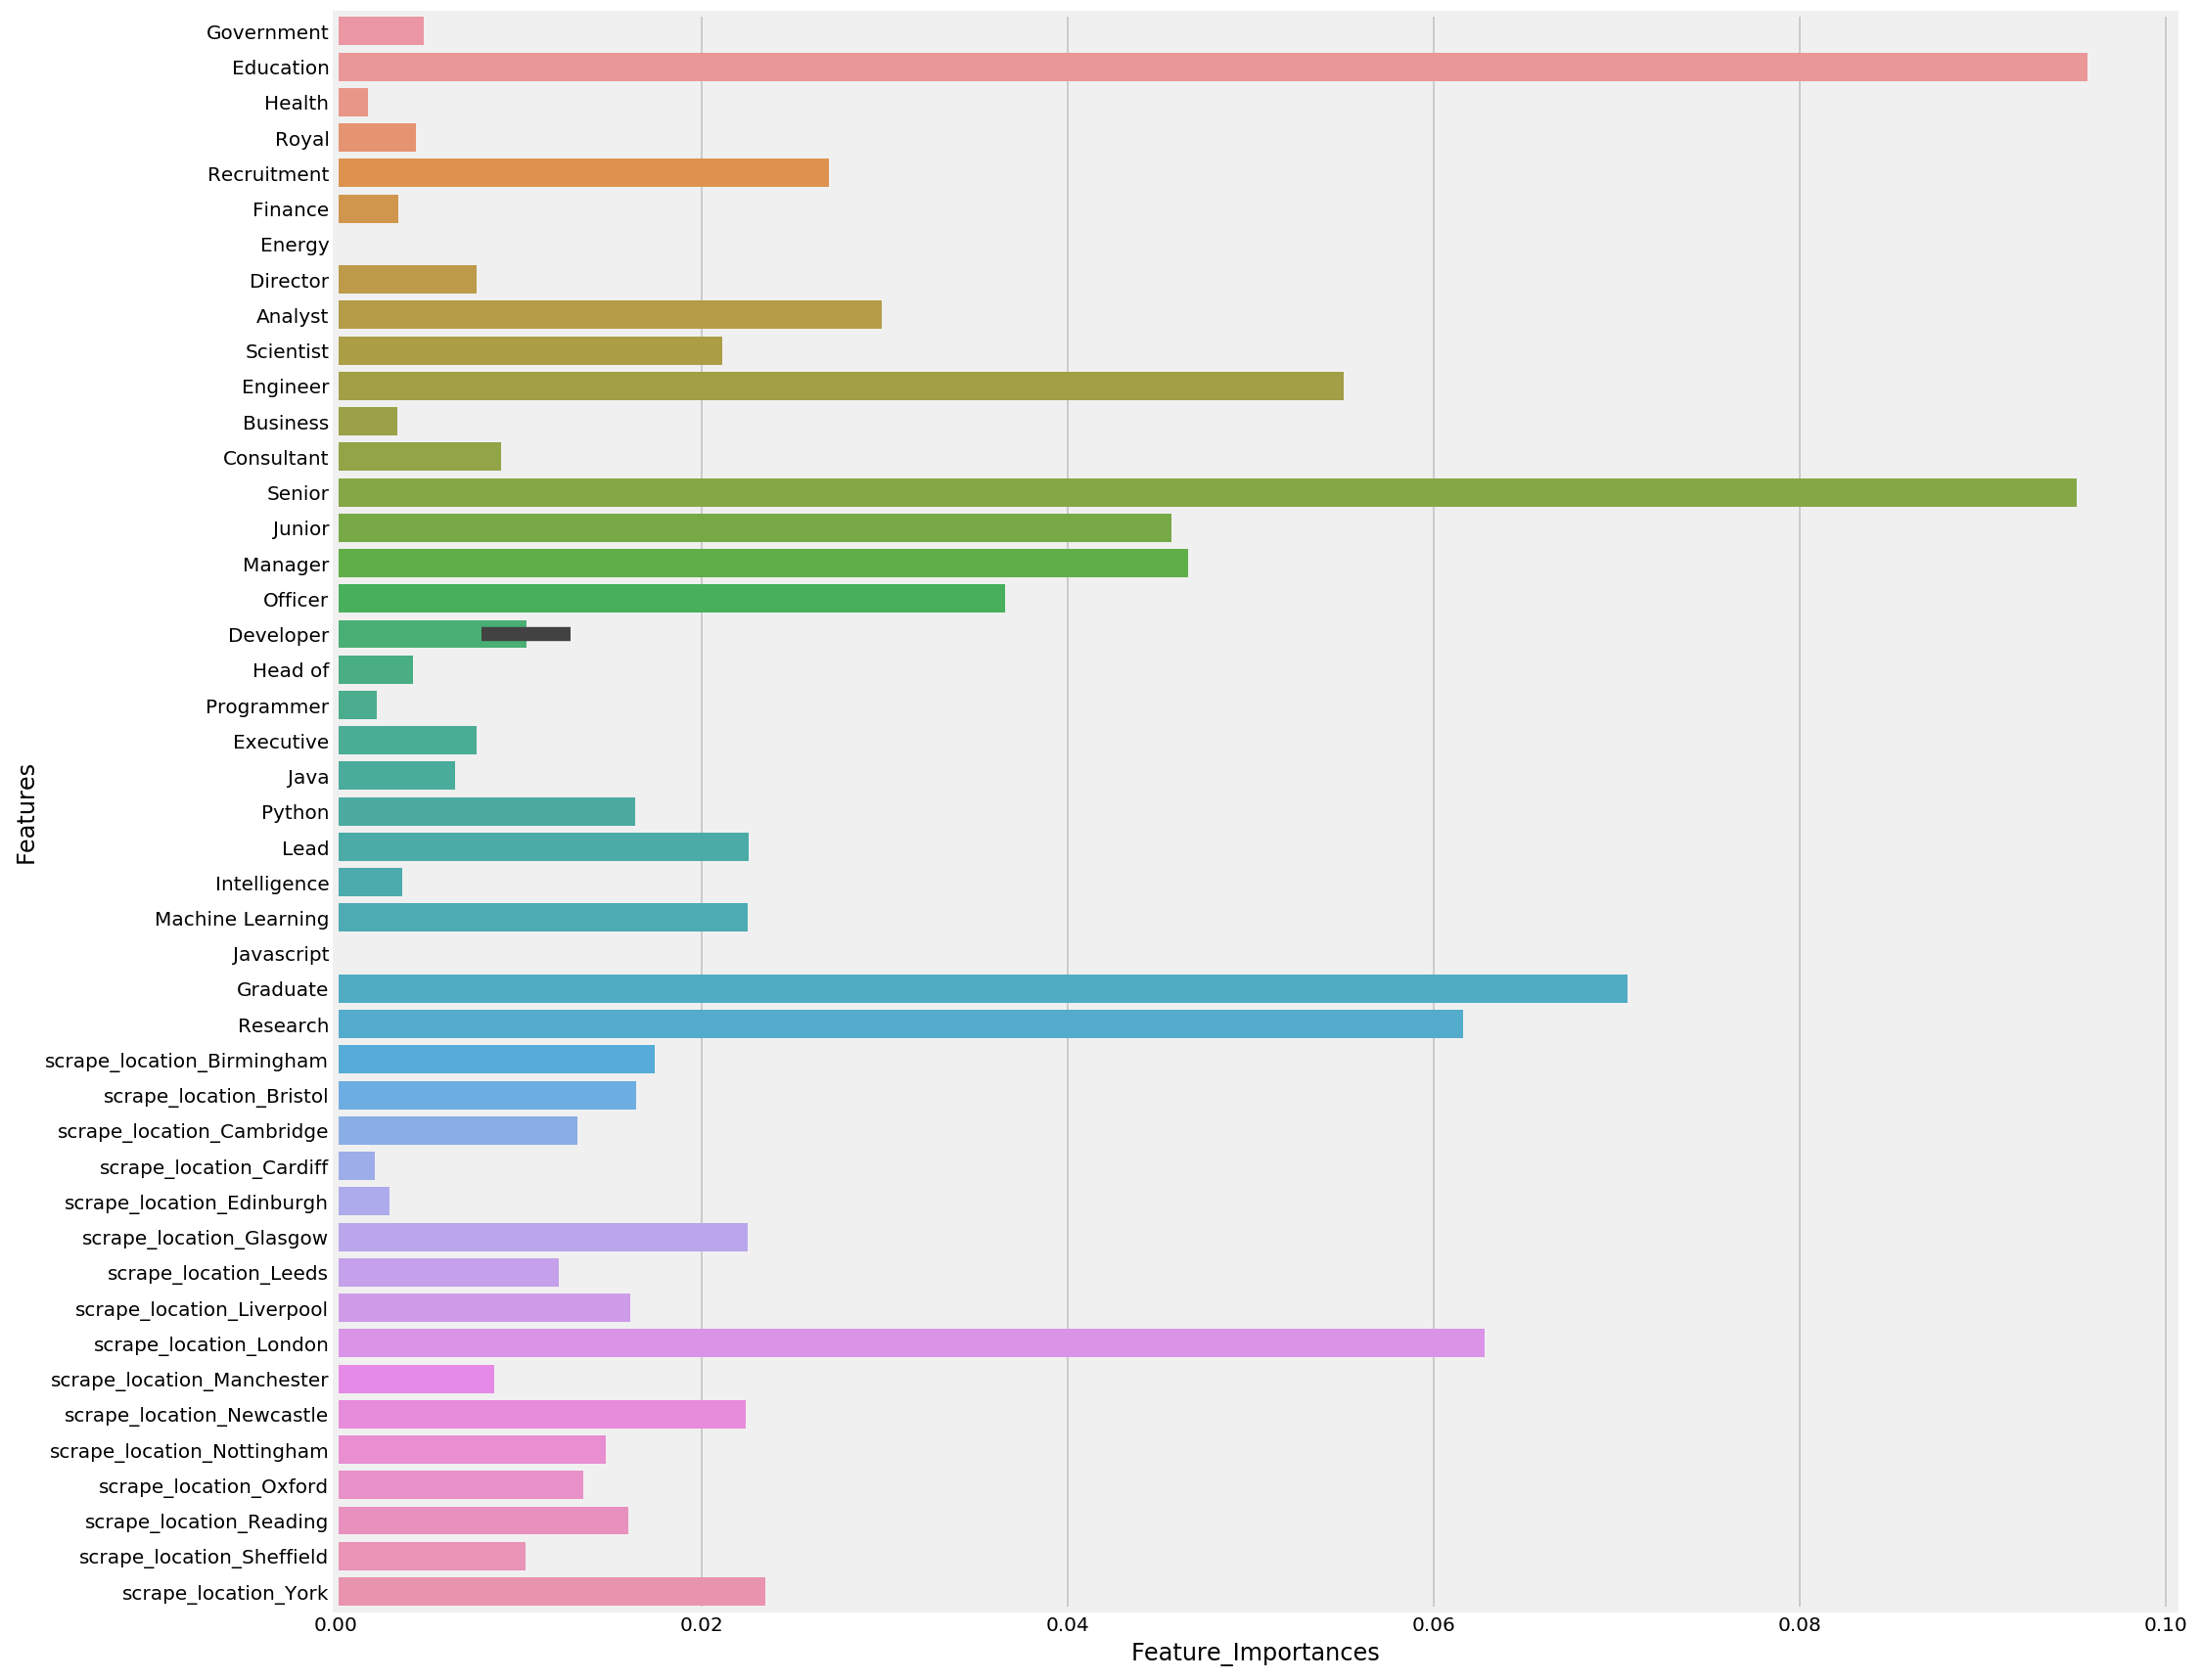

In [220]:
fig,ax= plt.subplots(figsize=(15,15))
sns.barplot(y=rf_coefficient_df.Features,x=rf_coefficient_df.Feature_Importances, orient='h',ax=ax);

In [227]:
predictions = best_rf.predict(X_test)
predictions_df = pd.DataFrame()
predictions_df['y_true'] = y_test
predictions_df['y_hat'] = predictions
predictions_df['prob_1'] = best_rf.predict_proba(X_test)[:,1]
predictions_df['70_percent_threshold'] = predictions_df['prob_1'].map(lambda x: 1 if x>0.7 else 0)
predictions_df.head(10)

,y_true,y_hat,prob_1,70_percent_threshold
1098,0,1,0.540857,0
311,1,1,0.876420,1
601,0,0,0.101680,0
49,1,1,0.746053,1
1073,1,1,0.680078,0
165,0,0,0.393103,0
28,0,1,0.609555,0
1091,1,1,0.824259,1
86,0,0,0.491725,0
604,1,0,0.429989,0


In [228]:
f1_score(y_test, predictions_df['70_percent_threshold'])

0.49056603773584906

In [229]:
fpr, tpr, thresh = roc_curve(y_test,predictions_df['prob_1'])
thresholds_df = pd.DataFrame()
thresholds_df['FPR'] = fpr
thresholds_df['TPR'] = tpr
thresholds_df['Thresholds'] = thresh

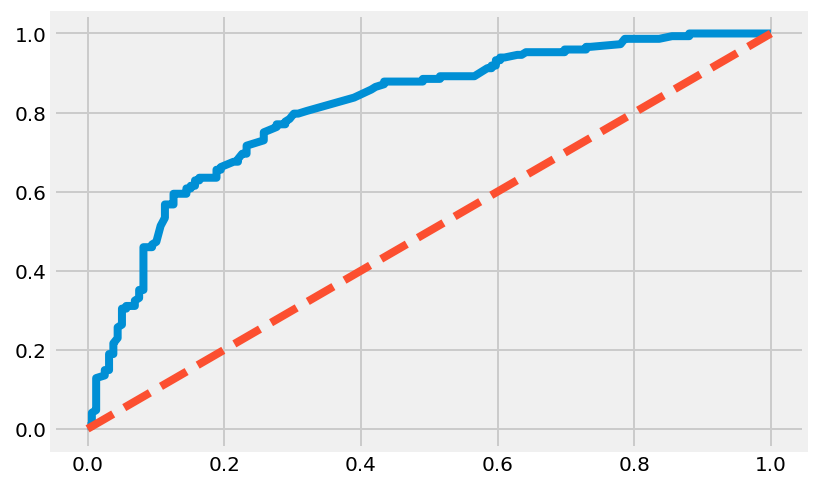

In [230]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'--');

### Summary

After determining the job title and employer keywords to create predictors for my models I ran Logistic Regression and Random Forest on my training data. After using GridSearch to find the optimal parameters for both models, the best score achieved on my testing data for the Logistic Regression model was an accuracy of 72.31%, while the best score for my optimised Random Trees model was 74.27%.

As the graphs above show, the Logistic Regression Model coefficients indicate that the keywords "Graduate", "Research", and "Education" are predictors of a low salary, while "Senior", "Manager" or "London" are indicators of a high salary. The Random Forest and it's Feature Importances metric tends to agree that these are key indicators, but it seems to place less significance on terms such as "Officer", or "Head of". This is most likely because these terms are much less frequently advertised job roles, and are therefore not best features in a decision tree.

In regards to the exercise of incorrectly classifying a job as low salary as opposed to high salary, this is a question of minimising false positives in the prediction. I would achieve this by increasing the threshold on my predictions, and classifying anything with less than 70% probability as a low income position. This would make my model less accurate, but increase its precision. The tradeoff for this task is illustrated in the ROC curve for each model, which gives a visualisation of the increased number of false positives for each increase in true positives that my models predict.